In [1]:
import numpy as np
from scipy.stats import norm, multivariate_normal
import matplotlib.pyplot as plt

from labellines import labelLine, labelLines
import glob
import pickle

from scipy.stats import entropy, kstest, cramervonmises, median_abs_deviation
import seaborn as sns
import statsmodels.api as sm

import warnings
warnings.filterwarnings("ignore")

In [ ]:
f = open('data/diagnostics/2d_coppit_pure_300.pkl', 'rb')
coppits_pure, pred_cdf_full_pure, true_cdf_full_pure, kendall_calibration_pure = pickle.load(f)

#  PIT values

In [5]:
#load the posteriors data
posterior_pure=np.load('data/posteriors/post_pure_all.npy',allow_pickle=True)
true_pure=np.load('data/posteriors/true_pure_all.npy')

posterior_hera=np.load('data/posteriors/post_hera_all.npy',allow_pickle=True)
true_hera=np.load('data/posteriors/true_hera_all.npy')

posterior_ska=np.load('data/posteriors/post_ska_all.npy',allow_pickle=True)
true_ska=np.load('data/posteriors/true_ska_all.npy')

### get metrics

In [6]:
#number of features 
no_features=2
#number of points to generate the calibration plots
no_points = 100

path='data/'
plot_folder='diagnostics/'

In [7]:
def get_pdf_metrics(pits, no_samples, no_features,  coppits=None):
    """Calculates performance metrics for PDFs."""

    pit_kst_p = np.empty(no_features)
    pit_cvm_p = np.empty(no_features)

    for feature in np.arange(no_features):
        pit_kst_p[feature] = kstest(pits[:, feature], 'uniform')[1]
        pit_cvm_p[feature] = cramervonmises(pits[:, feature], 'uniform').pvalue

    if coppits is not None:
        coppit_kst_p = kstest(coppits, 'uniform')[1]
        coppit_cvm_p = cramervonmises(coppits, 'uniform').pvalue
        return coppit_kst_p, coppit_cvm_p

    return pit_kst_p, pit_cvm_p

### probablistic calibration

In [8]:
def probabilistic_calibration(posteriors,no_samples,y_test):
    """Performs probabilistic calibration"""

    pits = np.empty(( no_samples,  no_features))

    for sample in np.arange( no_samples):
        posterior =  posteriors[sample][:]
        pits[sample] = np.sum(posterior <=  y_test[sample], axis=0) / posterior.shape[0]

    print('Completed probabilistic calibration.')
    return pits

In [9]:
pits_pure=probabilistic_calibration(posterior_pure,len(files_pure),true_pure)
pits_hera=probabilistic_calibration(posterior_hera,len(files_hera),true_hera)
pits_ska=probabilistic_calibration(posterior_ska,len(files_ska),true_ska)

Completed probabilistic calibration.
Completed probabilistic calibration.
Completed probabilistic calibration.


In [10]:
kst_p_pure, cvm_p_pure  = get_pdf_metrics(pits=pits_pure, no_samples=len(files_pure), no_features=no_features,
                                                   coppits=None)
kst_p_hera, cvm_p_hera  = get_pdf_metrics(pits=pits_hera, no_samples=len(files_hera), no_features=no_features,
                                                   coppits=None)
kst_p_ska, cvm_p_ska  = get_pdf_metrics(pits=pits_ska, no_samples=len(files_ska), no_features=no_features,
                                                   coppits=None)

In [11]:
print (kst_p_pure, cvm_p_pure)
print (kst_p_hera, cvm_p_hera)
print (kst_p_ska, cvm_p_ska)

[0.36847643 0.13801966] [0.13364774 0.05366703]
[0.16202463 0.30133612] [0.08812278 0.19839025]
[0.10869456 0.36200066] [0.09920842 0.35823578]


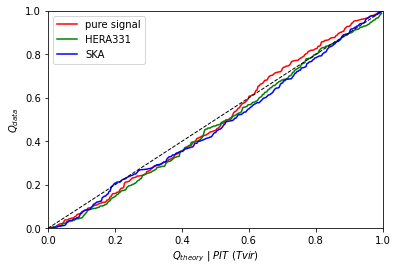

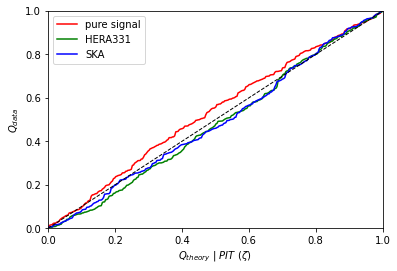

In [12]:
target_features = ['$Tvir$', '$\zeta$']
pits=[pits_pure,pits_hera,pits_ska]
colors=['r','g','b']
label=['pure signal','HERA331','SKA']
for feature in np.arange(no_features):
    fig,ax=plt.subplots(nrows=1,ncols=1)
    for i in range(3):
        qqplot = sm.qqplot(pits[i][:, feature], 'uniform', line='45').gca().lines
        qq_theory, qq_data = [qqplot[0].get_xdata(), qqplot[0].get_ydata()]
        plt.close()
        sns.lineplot(x=qq_theory, y=qq_data, ax=ax,color=colors[i],label=label[i])
    ax.plot([0, 1], [0, 1], color='black', linewidth=1, linestyle='--')

    ax.set_xlabel('$Q_{theory} \ | \ PIT \ ($' +  target_features[feature] + '$)$')
    ax.set_ylabel('$Q_{data}$')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])

    leg = plt.legend(loc='upper left')
            
    plt.savefig(path + plot_folder + 'var_' + str(feature) + '_pit.pdf',
                            bbox_inches='tight')
            
    plt.show()
    plt.close()

### marginal calibration

In [13]:
def marginal_calibration(posteriors,no_samples,y_test):
    """Performs marginal calibration"""

    points = np.linspace(np.floor(np.min( y_test, axis=0)), np.max( y_test, axis=0),  no_points)
    marginal_calibration = np.empty(( no_points,  no_features))

    for point in np.arange( no_points):
        probs = np.zeros( no_features)

        for sample in np.arange( no_samples):
            posterior =  posteriors[sample][:]
            probs += np.sum(posterior <= points[point], axis=0) / posterior.shape[0]

        pred_cdf_marg_point = probs /  no_samples
        true_cdf_marg_point = np.sum( y_test <= points[point], axis=0) /  no_samples
        marginal_calibration[point] = pred_cdf_marg_point - true_cdf_marg_point

    marginal_calibration = np.stack((points, marginal_calibration))
    print('Completed marginal calibration.')
    return marginal_calibration

In [14]:
marginal_calibration_pure=marginal_calibration(posterior_pure,len(files_pure),true_pure)
marginal_calibration_hera=marginal_calibration(posterior_hera,len(files_hera),true_hera)
marginal_calibration_ska=marginal_calibration(posterior_ska,len(files_ska),true_ska)

Completed marginal calibration.
Completed marginal calibration.
Completed marginal calibration.


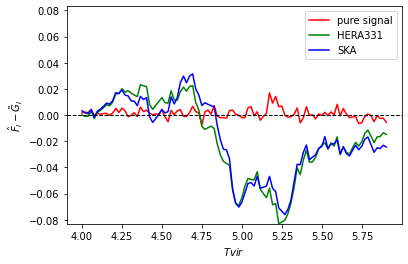

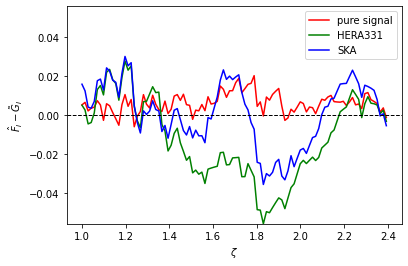

In [15]:
target_features = ['$Tvir$', '$\zeta$']
marginal_calibration=[marginal_calibration_pure,marginal_calibration_hera,marginal_calibration_ska]
colors=['r','g','b']
label=['pure signal','HERA331','SKA']
for feature in np.arange( no_features):
    for i in range(3):
        sns.lineplot(x=marginal_calibration[i][0, :, feature], y=marginal_calibration[i][1, :, feature], color=colors[i],label=label[i])

    plt.axhline(0, color='black', linewidth=1, linestyle='--')
    plt.ylim([-np.max(np.abs(np.array(marginal_calibration)[:,1, :, feature])),
                  np.max(np.abs(np.array(marginal_calibration)[:,1, :, feature]))])
    plt.xlabel( target_features[feature])
    plt.ylabel(r'$\hat{F}_{I} - \tilde{G}_{I}$')
    plt.savefig(path + plot_folder + 'var_' + str(feature) +
                            '_marginal_calibration.pdf', bbox_inches='tight')
    plt.show()
    plt.close()

# copPIT values

In [16]:
def create_templates(no_features):
    """Creates templates to perform multivariate calibration"""

    template = []
    template_same = []
    for feature in np.arange(no_features):

        if feature != (no_features - 1):
            template.append('(posterior[:,' + str(feature) + '] < posterior[pred,' + str(feature) + ']) & ')
            template_same.append('(posterior[:,' + str(feature) + '] == posterior[pred,' + str(feature) + ']) & ')
        else:
            template.append('(posterior[:,' + str(feature) + '] < posterior[pred,' + str(feature) + '])')
            template_same.append('(posterior[:,' + str(feature) + '] == posterior[pred,' + str(feature) + '])')

    template_pred = ''.join(template)
    template_same = ''.join(template_same)
    template_true = template_pred.replace('posterior[pred', 'y_test[sample')
    template_true = template_true.replace('<', '<=')

    return template_pred, template_true, template_same

In [17]:
def probabilistic_copula_calibration(posteriors,no_samples,y_test):
    """Performs probabilistic copula calibration"""

    # Creating a list of list containing pred_cdf of each point in predictions
    pred_cdf_full = [[] for i in np.arange( no_samples)]
    true_cdf_full = []
    coppits = np.empty( no_samples)
    template_pred, template_true, template_same = create_templates(no_features= no_features)

    for sample in np.arange( no_samples):
        posterior =  posteriors[sample][:]
        no_preds = posterior.shape[0]

        for pred in np.arange(no_preds):
            # For point at edges, if <= used, then point counts and cdf is never 0.
            # If <= is used and the full MCMC chains are used, a large number of point will have near 0 probability, as a result, there will
            # be a peak at 0. The point in consideration does not count when determining cdf.
            # If we only use the accepted chains, this should not be the problem.
            same_preds = np.sum(eval(template_same))
            pred_cdf_full[sample].append(np.sum(eval(template_pred)) / (no_preds - same_preds))

        true_cdf_full.append(np.sum(eval(template_true)) / no_preds)
        coppits[sample] = np.sum(pred_cdf_full[sample] <= true_cdf_full[sample]) / no_preds

    print('Completed probabilistic copula calibration.')
    return coppits, pred_cdf_full, true_cdf_full

In [ ]:
f = open('data/diagnostics/2d_coppit_pure_300.pkl', 'rb')
coppits_pure, pred_cdf_full_pure, true_cdf_full_pure, kendall_calibration_pure = pickle.load(f)
f = open('data/diagnostics/2d_coppit_hera_300.pkl', 'rb')
coppits_hera, pred_cdf_full_hera, true_cdf_full_hera, kendall_calibration_hera = pickle.load(f)
f = open('data/diagnostics/2d_coppit_ska_300.pkl', 'rb')
coppits_ska, pred_cdf_full_ska, true_cdf_full_ska, kendall_calibration_ska = pickle.load(f)

In [19]:
coppits_pure, pred_cdf_full_pure, true_cdf_full_pure=probabilistic_copula_calibration(np.array(posterior_pure),len(files_pure),true_pure)
coppits_hera, pred_cdf_full_hera, true_cdf_full_hera=probabilistic_copula_calibration(np.array(posterior_hera),len(files_hera),true_hera)
coppits_ska, pred_cdf_full_ska, true_cdf_full_ska=probabilistic_copula_calibration(np.array(posterior_ska),len(files_ska),true_ska)

In [20]:
kst_p_pure_coppit, cvm_p_pure_coppit  = get_pdf_metrics(pits=pits_pure, no_samples=len(files_pure), no_features=no_features,
                                                  coppits=coppits_pure)
kst_p_hera_coppit, cvm_p_hera_coppit  = get_pdf_metrics(pits=pits_hera, no_samples=len(files_hera), no_features=no_features,
                                                  coppits=coppits_hera)
kst_p_ska_coppit, cvm_p_ska_coppit  = get_pdf_metrics(pits=pits_ska, no_samples=len(files_ska), no_features=no_features,
                                                  coppits=coppits_ska)

In [21]:
print (kst_p_pure_coppit, cvm_p_pure_coppit)
print (kst_p_hera_coppit, cvm_p_hera_coppit)
print (kst_p_ska_coppit, cvm_p_ska_coppit)

0.5353065217626118 0.392439276620031
0.13403620610902445 0.16789791399369636
0.22425685847071575 0.2905327137225986


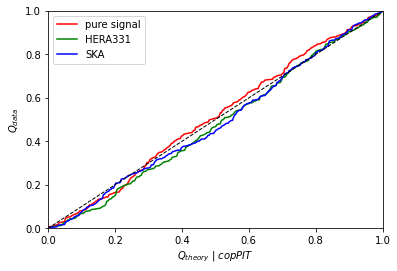

In [22]:
coppits=[coppits_pure,coppits_hera,coppits_ska]
colors=['r','g','b']
label=['pure signal','HERA331','SKA']
fig,ax=plt.subplots(nrows=1,ncols=1)
for i in range(3):
    qqplot = sm.qqplot(coppits[i], 'uniform', line='45').gca().lines
    qq_theory, qq_data = [qqplot[0].get_xdata(), qqplot[0].get_ydata()]
    plt.close()

    sns.lineplot(x=qq_theory, y=qq_data, ax=ax,color=colors[i],label=label[i])
ax.plot([0, 1], [0, 1], color='black', linewidth=1, linestyle='--')

ax.set_xlabel('$Q_{theory} \ | \ copPIT$')
ax.set_ylabel('$Q_{data}$')
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])

leg = plt.legend(loc='upper left')
            
plt.savefig(path + plot_folder + 'coppit.pdf', bbox_inches='tight')
            
plt.show()
plt.close()

### Kendall calibration

In [23]:
def kendall_calibration(pred_cdf_full, true_cdf_full,no_samples):
    """Performs kendall calibration"""

    kendall_calibration = np.empty( no_points)
    count = 0 

    for point in np.linspace(0, 1,  no_points):
        sum_ = np.zeros( no_samples)
        for sample in np.arange( no_samples):
            sum_[sample] = np.sum(pred_cdf_full[sample] <= point) / len(pred_cdf_full[sample])

        kendall_func_point = np.sum(sum_) /  no_samples
        true_cdf_point = np.sum(true_cdf_full <= point) /  no_samples
        kendall_calibration[count] = kendall_func_point - true_cdf_point
        count += 1

    print('Completed kendall calibration.')
    return kendall_calibration

In [24]:
kendall_calibration_pure = kendall_calibration(pred_cdf_full_pure, true_cdf_full_pure,len(files_pure))
kendall_calibration_hera = kendall_calibration(pred_cdf_full_hera, true_cdf_full_hera,len(files_hera))
kendall_calibration_ska = kendall_calibration(pred_cdf_full_ska, true_cdf_full_ska,len(files_ska))

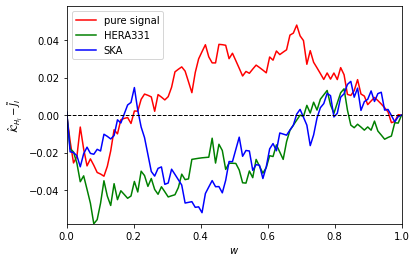

In [25]:
kendall_calibration=[kendall_calibration_pure,kendall_calibration_hera,kendall_calibration_ska]
colors=['r','g','b']
label=['pure signal','HERA331','SKA']
for i in range(3):
    sns.lineplot(x=np.linspace(0, 1,  no_points), y=kendall_calibration[i], color=colors[i],label=label[i])

plt.axhline(0, color='black', linewidth=1, linestyle='--')
plt.xlim([0, 1]) 
plt.ylim([-np.max(np.abs(np.array(kendall_calibration))),
                  np.max(np.abs(np.array(kendall_calibration)))])
plt.xlabel('$w$')
plt.ylabel(r'$\mathcal{\hat{K}}_{H_{I}}  - \tilde{J}_{I}$')
plt.savefig(path + plot_folder + 'var_' + str(feature) +
                            '_kendall_calibration.pdf', bbox_inches='tight')
plt.show()
plt.close()

# HPD values (hera, for other levels of signals the processes are similar)

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pydelfi.priors as priors
import pydelfi.ndes as ndes
import pydelfi.delfi as delfi
import tensorflow as tf

### the hpd values built from scratch (run the following blocks if you have posterior samples)

In [6]:
#directory to load the trained ndes
diri = "data/model/trained_hera/" 

#validation data
theta_fiducials = np.load('data/hera_para_validation.npy')
compressed_datas = np.load('data/hera_ps_validation.npy')

nd=compressed.shape[1]

theta_fiducial = theta_fiducials[0] 
compressed_data = compressed_datas[0] 

lower = np.array([4,1])
upper = np.array([6,2.398])
prior = priors.Uniform(lower, upper)

NDEs = [ndes.ConditionalMaskedAutoregressiveFlow(n_parameters=2, n_data=nd, n_hiddens=[50,50], n_mades=5, act_fun=tf.tanh, index=0),
            ndes.ConditionalMaskedAutoregressiveFlow(n_parameters=2, n_data=nd, n_hiddens=[50,50], n_mades=5, act_fun=tf.tanh, index=1),
            ndes.ConditionalMaskedAutoregressiveFlow(n_parameters=2, n_data=nd, n_hiddens=[50,50], n_mades=5, act_fun=tf.tanh, index=2),
            ndes.ConditionalMaskedAutoregressiveFlow(n_parameters=2, n_data=nd, n_hiddens=[50,50], n_mades=5, act_fun=tf.tanh, index=3)]

DelfiEnsemble = delfi.Delfi(compressed_data, prior, NDEs,
                            Finv = None,
                            n_procs = 1,
                            theta_fiducial = theta_fiducial,
                            param_limits = [lower, upper],
                            param_names = ['\mathrm{log_{10}\,T_{vir}}', '\mathrm{log_{10}\,\zeta}'],
                            results_dir = diri,
                            progress_bar = False,
                            save = False,
                            restore = True,
                            input_normalization=None)





Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from /scratch/zxs/scripts/st/job/pos_results1559/pos_1/graph_checkpoint


In [7]:
def probabilistic_hpd_calibration(posteriors,no_samples,y_test,compressed,prob):
    """
    Performs probabilistic calibration
    :posteriors: numpy array of a list of posteriors
    :no_samples: the number of validation samples
    :y_test: the true parameters of the validation samples
    :compressed: the mock observation data of the validation samples
    :prob: the probability of each point in the posterior chain (from MCMC sampling)
    """

    hpds = np.empty(( no_samples))
    for sample in np.arange( no_samples):
        posterior =  posteriors[sample][:]
        true_prob=DelfiEnsemble.log_posterior_stacked(y_test[sample], compressed[sample])
        hpds[sample] = np.sum(prob[sample]>=true_prob)/len(posterior)

    print('Completed probabilistic hpd calibration.')
    return hpds

In [ ]:
"""
posteriors=
prob=
"""

In [9]:
hpds_hera=probabilistic_hpd_calibration(posteriors,len(theta_fiducials),theta_fiducials,compressed_datas,prob)

Completed probabilistic hpd calibration.


In [42]:
pit_kst_p = kstest(hpds_hera, 'uniform')[1]
pit_cvm_p = cramervonmises(hpds_hera, 'uniform').pvalue
print (pit_kst_p)
print (pit_cvm_p)

0.005524662587139912
0.0014941571512746554


### probablistic calibration plot (directly load the hpd values from the directory)

In [ ]:
hpds_pure=np.load('data/diagnostics/hpd_pure.npy') #1556
hpds_hera=np.load('data/diagnostics/hpd_hera.npy')
hpds_ska=np.load('data/diagnostics/hpd_ska.npy')

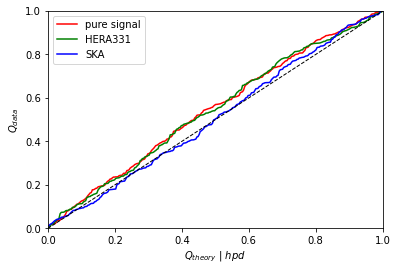

In [27]:
hpds=[hpds_pure,hpds_hera,hpds_ska]
colors=['r','g','b']
label=['pure signal','HERA331','SKA']
fig,ax=plt.subplots(nrows=1,ncols=1)
for i in range(3):
    qqplot = sm.qqplot(hpds[i], 'uniform', line='45').gca().lines
    qq_theory, qq_data = [qqplot[0].get_xdata(), qqplot[0].get_ydata()]
    plt.close()

    sns.lineplot(x=qq_theory, y=qq_data, ax=ax,color=colors[i],label=label[i])
ax.plot([0, 1], [0, 1], color='black', linewidth=1, linestyle='--')

ax.set_xlabel('$Q_{theory} \ | \ hpd$')
ax.set_ylabel('$Q_{data}$')
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])

leg = plt.legend(loc='upper left')
            
plt.savefig(path + plot_folder + 'hpd.pdf', bbox_inches='tight')
            
plt.show()
plt.close()